# EchoCare: Cry Classification Model Training
## Stage 2 of Two-Stage Pipeline

This notebook trains a binary classification model to detect pain cries vs hungry cries in infants.

**Dataset:**
- Baby Chillanto Dataset 

**Categories:**
- Pain
- Hungry

**Target Performance:** >70% accuracy for cry classification

**Architecture:** MobileNetV2 (lightweight for Raspberry Pi deployment) with custom classification head

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Configuration

In [2]:
# Paths
train_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_classification/train")
val_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_classification/validate")
test_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/dataset/processed/mel-spectrograms/cry_classification/test")
save_dir = Path("C:/Users/danel/FYP/echocare-infant-cry-classification/model/cry_classification")

# Model hyperparameters
img_size = (224, 224)  # MobileNetV2 input size
batch_size = 32
epochs = 30
learning_rate = 0.0001
dropout_rate1 = 0.4
dropout_rate2 = 0.3

# Class information
class_names = ['pain', 'hungry']
num_classes = 2

## 3. Data Loading Functions

In [3]:
def load_spectrograms(data_dir, verbose=True):
    """
    Load .npy spectrograms from directory structure.

    Args:
        data_dir: Path object or string path to directory containing pain/hungry folders
        verbose: Print loading progress
    
    Returns:
        spectrograms: numpy array of spectrograms
        labels: numpy array of labels (0=pain, 1=hungry)
    """

    spectrograms = []
    labels = []
    
    # Load hungry mel-spectrograms (label = 1)
    hungry_dir = data_dir / 'hungry'  # Find the 'hungry' subfolder
    hungry_files = list(hungry_dir.glob('*.npy')) # Get all .npy files in the 'hungry' folder
    
    for file in hungry_files: # Load each hungry file and label it as 1 (hungry = 1)
        spec = np.load(file) # load the .npy (mel spectrogram) file
        spectrograms.append(spec) # add to mel-spectrograms list
        labels.append(1) # label as hungry (1)
    
    if verbose:
        print(f"Loaded {len(hungry_files)} hungry spectrograms")
    
    # Load pain spectrograms (label = 0)
    pain_dir = data_dir / 'pain'
    pain_files = list(pain_dir.glob('*.npy'))
    
    for file in pain_files: # Load each pain file and label it as 0 (pain = 0)
        spec = np.load(file)
        spectrograms.append(spec)
        labels.append(0)
    
    if verbose:
        print(f"Loaded {len(pain_files)} pain spectrograms")
        print(f"Total samples: {len(spectrograms)}")
    
    return np.array(spectrograms), np.array(labels)

## 4. Prepare Mel-Spectrograms for MobileNetV2 Architecture

In [4]:
def prepare_for_mobilenet(spectrograms, target_size=(224, 224)):
    """
    Prepare mel-spectrograms for MobileNetV2 input.
    
    Transforms all mel-spectrograms from (128, 32) grayscale format to (224, 224, 3) RGB format required by MobileNetV2's pre-trained weights from ImageNet.
    
    Process:
    1. Input: (128, 32) - 128 mel bands x 32 time frames
    2. Add channel: (128, 32, 1) - add dimension for grayscale
    3. Resize: (224, 224, 1) - match MobileNetV2 input size
    4. Repeat channels: (224, 224, 3) - convert to RGB by duplicating grayscale values
    
    Args:
        spectrograms: numpy array of mel-spectrograms with shape (n_samples, 128, 32)
        target_size: tuple (height, width) for resizing, default (224, 224)
    
    Returns:
        prepared: numpy array with shape (n_samples, 224, 224, 3)
    """
    prepared = []
    
    for spec in spectrograms:
        # Step 1: Add channel dimension
        # Transform from (128, 32) to (128, 32, 1)
        # This prepares the 2D mel-spectrogram for image processing
        if len(spec.shape) == 2:
            spec = np.expand_dims(spec, axis=-1)  # Expand the shape of the array. Shape: (128, 32, 1)
        
        # Step 2: Resize to MobileNetV2's expected input size
        # Transform from (128, 32, 1) to (224, 224, 1)
        # Width stretches from 32 → 224 frames (7x expansion)
        # Height expands from 128 → 224 mel bands (~1.75x expansion)
        resized = cv2.resize(spec, target_size)  # Expand the shape of the array. Shape: (224, 224, 1)
        
        # Step 3: Ensure channel dimension exists after resize
        if len(resized.shape) == 2:
            resized = np.expand_dims(resized, axis=-1)  # Shape: (224, 224, 1)
        
        # Step 4: Convert grayscale (1 channel) to RGB (3 channels)
        # Transform from (224, 224, 1) to (224, 224, 3)
        # Creates "fake RGB" by duplicating the same values across R, G, B channels
        # This allows MobileNetV2 (trained on colour images) to process the grayscale spectrograms
        if resized.shape[-1] == 1:
            resized = np.repeat(resized, 3, axis=-1)  # Final shape: (224, 224, 3)
        
        prepared.append(resized) # add to prepared list
    
    return np.array(prepared, dtype=np.float32)

## 5. Load and Visualise Cry Classification (Pain vs Hungry) Data

In [5]:
# Load training data
print("Loading training data...")
X_train_raw, y_train = load_spectrograms(train_dir)

# Load validation data
print("\nLoading validation data...")
X_val_raw, y_val = load_spectrograms(val_dir)

# Load test data
print("\nLoading test data...")
X_test_raw, y_test = load_spectrograms(test_dir)

print(f"Training samples: {len(X_train_raw)}")
print(f"Validation samples: {len(X_val_raw)}")
print(f"Test samples: {len(X_test_raw)}")
print(f"Raw spectrogram shape: {X_train_raw[0].shape}")

Loading training data...
Loaded 245 hungry spectrograms
Loaded 134 pain spectrograms
Total samples: 379

Loading validation data...
Loaded 52 hungry spectrograms
Loaded 29 pain spectrograms
Total samples: 81

Loading test data...
Loaded 53 hungry spectrograms
Loaded 29 pain spectrograms
Total samples: 82
Training samples: 379
Validation samples: 81
Test samples: 82
Raw spectrogram shape: (128, 32)


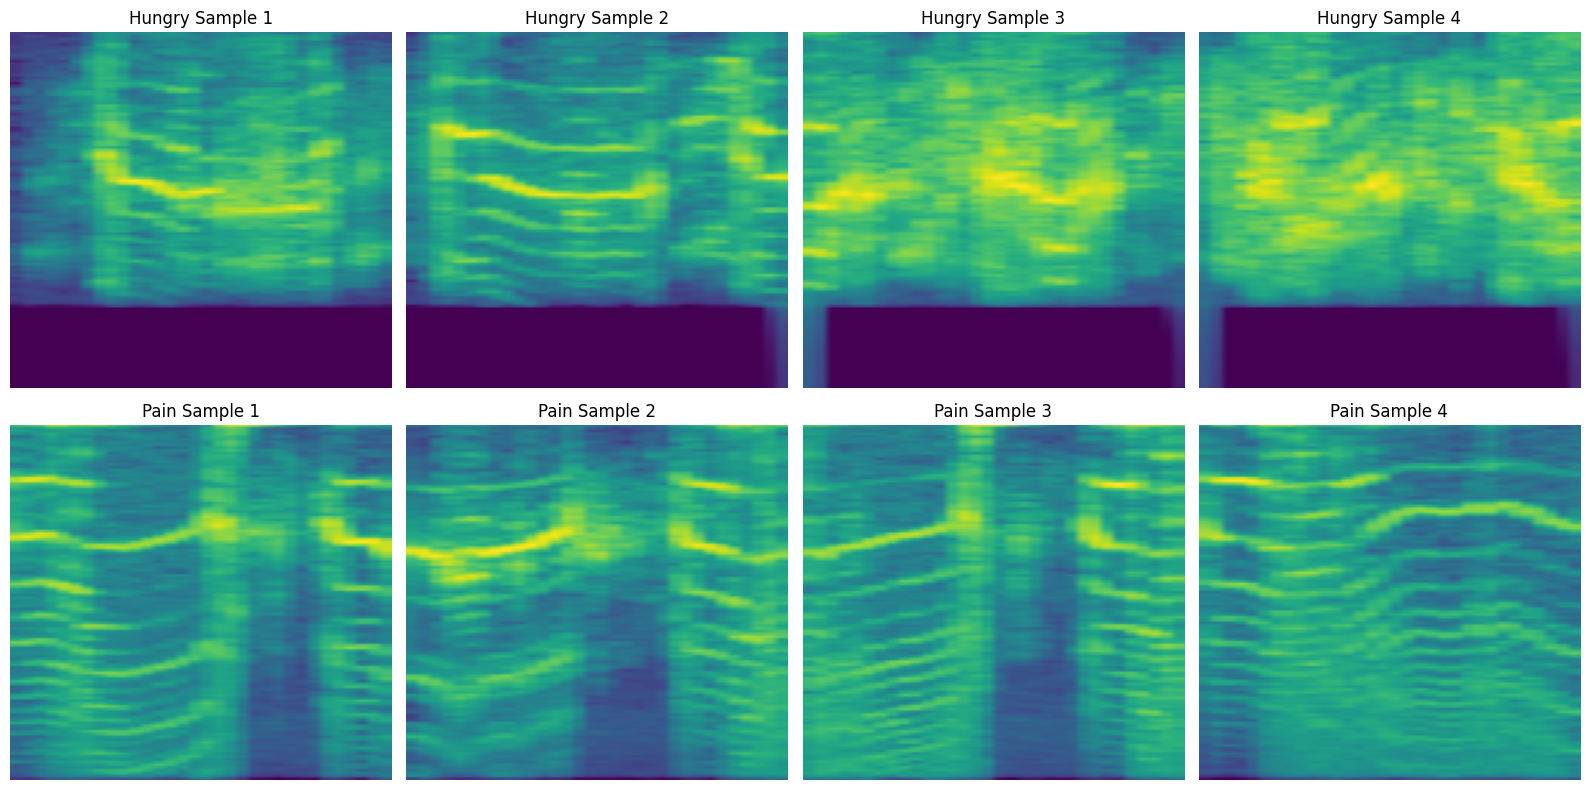

In [6]:
# Visualise sample spectrograms
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Find 4 hungry samples (where label = 1)
hungry_indices = np.where(y_train == 1)[0][60:64]

# Find 4 pain samples (where label = 0)  
pain_indices = np.where(y_train == 0)[0][60:64]

# Plot 4 hungry samples in top row
for i in range(4):
    spec = X_train_raw[hungry_indices[i]]  # Get hungry mel-spectrogram (128 mel bands × 32 time frames)
    axes[0, i].imshow(spec, aspect='auto')
    axes[0, i].set_title(f'Hungry Sample {i+1}')
    axes[0, i].axis('off')

# Plot 4 pain samples in bottom row
for i in range(4):
    spec = X_train_raw[pain_indices[i]]  # Get pain mel-spectrogram (128 mel bands × 32 time frames)
    axes[1, i].imshow(spec, aspect='auto')
    axes[1, i].set_title(f'Pain Sample {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 6. Normalising Mel-Spectrograms

In [7]:
# Calculate normalisation parameters from training set only
mean = np.mean(X_train_raw)
std = np.std(X_train_raw)

print(f"Training set statistics:")
print(f"Mean: {mean:.2f}")
print(f"Std:  {std:.2f}")
print(f"Min:  {np.min(X_train_raw):.2f}")
print(f"Max:  {np.max(X_train_raw):.2f}")

# Apply standardisation (z-score normalisation)
X_train_norm = (X_train_raw - mean) / std
X_val_norm = (X_val_raw - mean) / std
X_test_norm = (X_test_raw - mean) / std

print("\nAfter normalisation:")
print(f"Training mean: {np.mean(X_train_norm):.2f} ") # (should be ~0)
print(f"Training std:  {np.std(X_train_norm):.2f} ") # (should be ~1)

# Show normalisation parameters for deployment on Raspberry Pi
normalisation_params = {
    "mean": float(mean),
    "std": float(std),
    "method": "standardisation"
}

print(normalisation_params)

Training set statistics:
Mean: -40.55
Std:  19.65
Min:  -80.00
Max:  0.00

After normalisation:
Training mean: -0.00 
Training std:  1.00 
{'mean': -40.55323028564453, 'std': 19.64647102355957, 'method': 'standardisation'}


## 7. Preparing Data for MobileNetV2

In [8]:
# Resize and convert to 3-channel format
print("Preparing data for MobileNetV2")

X_train = prepare_for_mobilenet(X_train_norm, target_size=img_size) # prepare training set
X_val = prepare_for_mobilenet(X_val_norm, target_size=img_size) # prepare validation set
X_test = prepare_for_mobilenet(X_test_norm, target_size=img_size) # prepare test set

print(f"\nFinal shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\n  y_train: {y_train.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

Preparing data for MobileNetV2

Final shapes:
  X_train: (379, 224, 224, 3)
  X_val:   (81, 224, 224, 3)
  X_test:  (82, 224, 224, 3)

  y_train: (379,)
  y_val:   (81,)
  y_test:  (82,)


## 8. Calculating Class Weights

In [9]:
# Compute class weights to handle imbalance
# Training set has: 245 hungry sounds, 134 pain sounds

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights to handle imbalance:")
for cls, weight in class_weights.items():
    print(f"{class_names[cls]}: {weight:.4f}")

print("\nThis gives more importance to the minority class (pain) during training.")

Class weights to handle imbalance:
pain: 1.4142
hungry: 0.7735

This gives more importance to the minority class (pain) during training.


## 9. Building Cry Classification Model

In [10]:
def build_cry_classification_model(input_shape=(224, 224, 3), dropout_rate1=0.4, dropout_rate2=0.3):
    """
    Build MobileNetV2-based binary classifier for cry classification.
    
    Args:
        input_shape: Input image shape
        dropout_rate: Dropout rate for preventing overfitting
    
    Returns:
        model: Compiled Keras model
    """
    # Load MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False, # Exclude final classification layer
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(dropout_rate1, name='dropout_1')(x)
    x = Dense(32, activation='relu', name='dense_32')(x)
    x = Dropout(dropout_rate2, name='dropout_2')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)  # Binary classification
    
    # Create model
    model = Model(inputs=base_model.input, outputs=output, name='CryClassificationModel')
    
    return model

In [11]:
# Build the model
model = build_cry_classification_model(
    input_shape=(img_size[0], img_size[1], 3), # MobileNetV2 expects 3-channel input
    dropout_rate1=dropout_rate1,
    dropout_rate2=dropout_rate2
)

## 10. Compiling the Model

In [12]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled successfully")
print(f"\nOptimiser: Adam (lr={learning_rate})")
print(f"Loss: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Model compiled successfully

Optimiser: Adam (lr=0.0001)
Loss: Binary Crossentropy
Metrics: Accuracy, Precision, Recall


## 11. Setting up Callbacks

In [13]:
# Define callbacks
callbacks = [

    # Save best model based on validation accuracy
    ModelCheckpoint(
        filepath=str(save_dir / 'best_model_classification.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    ),
    
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=7,
        restore_best_weights=True
    )
]

print("Callbacks configured:")
print("ModelCheckpoint")
print("EarlyStopping")

Callbacks configured:
ModelCheckpoint
EarlyStopping


## 12. Training the Model

In [14]:
print("Starting training...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights,  # Handle class imbalance
    callbacks=callbacks,
    verbose=1
)

print("Training completed")

Starting training...

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.5409 - loss: 0.9037 - precision: 0.6461 - recall: 0.6408 - val_accuracy: 0.4815 - val_loss: 0.6950 - val_precision: 0.6389 - val_recall: 0.4423
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.5251 - loss: 0.7251 - precision: 0.6796 - recall: 0.5020 - val_accuracy: 0.5309 - val_loss: 0.6883 - val_precision: 0.7188 - val_recall: 0.4423
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.5567 - loss: 0.7290 - precision: 0.6915 - recall: 0.5673 - val_accuracy: 0.6173 - val_loss: 0.6286 - val_precision: 0.7059 - val_recall: 0.6923
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.6412 - loss: 0.6504 - precision: 0.7466 - recall: 0.6735 - val_accuracy: 0.6667 - val_loss: 0.6201 - val_precision: 0.7451 - val_recall: 0.7308
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.6253 - loss: 0.6531 - precision: 0.7395 - recall: 0.6490 - val_accuracy:

## 13. Plotting the Training History

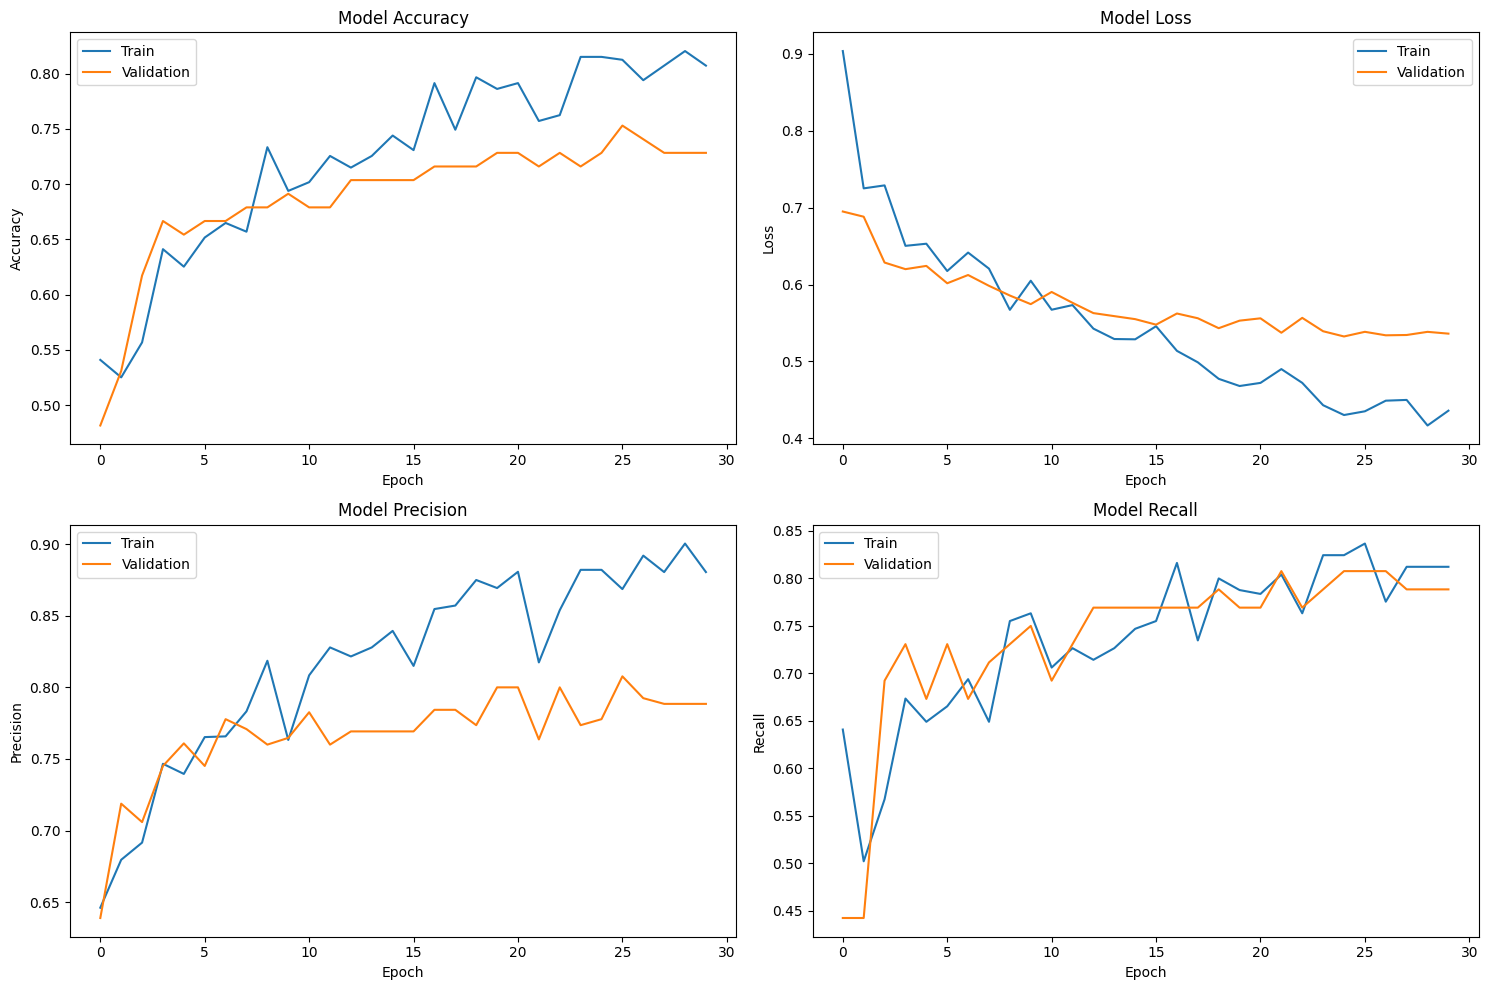

In [16]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 14. Loading Best Model and Evaluating on Test Set

In [15]:
# Load the best saved model
best_model = keras.models.load_model(save_dir / 'best_model_classification.keras') 
print("Best model loaded successfully")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = best_model.evaluate(X_test, y_test, verbose=1)

print("Results on Test Set")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

Best model loaded successfully

Evaluating on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.7561 - loss: 0.5577 - precision: 0.8113 - recall: 0.8113
Results on Test Set
Test Loss: 0.5577
Test Accuracy: 0.7561
Test Precision: 0.8113
Test Recall: 0.8113


## 15. Generating Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step


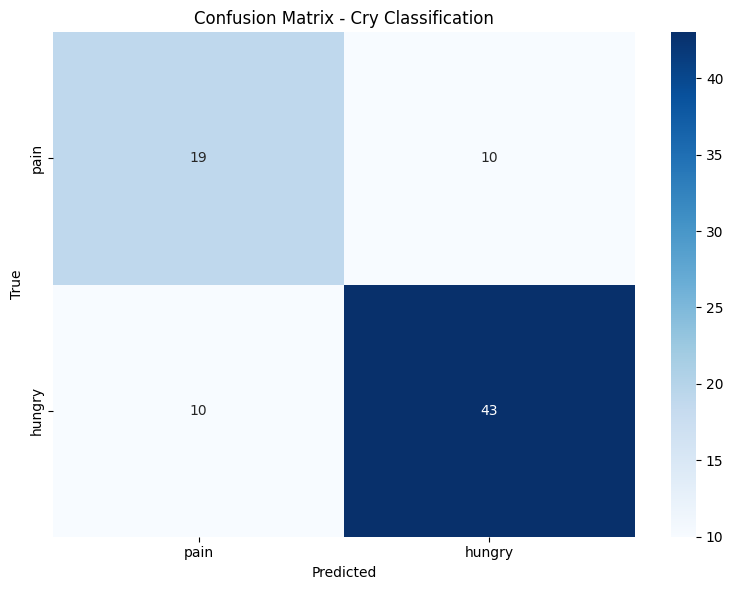


Confusion Matrix:
True Negatives (pain correctly identified): 19
False Positives (pain wrongly as hungry): 10
False Negatives (hungry wrongly as pain): 10
True Positives (hungry correctly identified):  43


In [17]:
# Generate predictions on test set
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Cry Classification')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(f"True Negatives (pain correctly identified): {cm[0, 0]}")
print(f"False Positives (pain wrongly as hungry): {cm[0, 1]}")
print(f"False Negatives (hungry wrongly as pain): {cm[1, 0]}")
print(f"True Positives (hungry correctly identified):  {cm[1, 1]}")

## 16. Summary

In [18]:
print("Training Summary")

print(f"\nModel Performance:")
print(f"  Test Accuracy: {test_results[1]*100:.2f}%")
print(f"  Test Precision: {test_results[2]*100:.2f}%")
print(f"  Test Recall: {test_results[3]*100:.2f}%")

Training Summary

Model Performance:
  Test Accuracy: 75.61%
  Test Precision: 81.13%
  Test Recall: 81.13%
